# Food-101 Training: Scratch, Transfer (Linear Probe), Fine-tune

This notebook loads the config, builds dataloaders with augmentation and imbalance handling, and trains:
- Scratch: SimpleCNN / ResNet-18 from scratch
- Transfer: ResNet-50 or ResNet-18 frozen backbone (linear probe)
- Fine-tune: Unfreeze last stage(s)

It also computes accuracy, macro-F1, and shows confusion matrices and augmentation impact.


In [2]:
import os, json, math, random
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as tvm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import FoodDataset

PROJECT_ROOT = Path(r"/home/vn5378/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101") #Change based on your own path
CONFIG_PATH = "/home/vn5378/Documents/Image_Classification_DL/config.json"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = json.load(f)

FOOD101_ROOT = Path(cfg["dataset_root"])  # has images/ and meta/
CLASS_NAMES: List[str] = cfg["class_names"]
IMAGE_SIZE: int = int(cfg.get("image_size", 128))
SPLIT_PROTOCOL: str = cfg.get("split_protocol", "standard")
SEED: int = int(cfg.get("seed", 42))

print("Loaded config:", cfg)


Loaded config: {'dataset_root': '/home/vn5378/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101', 'class_names': ['apple_pie', 'beef_carpaccio', 'beef_tartare', 'caesar_salad', 'caprese_salad', 'carrot_cake', 'cheesecake', 'club_sandwich', 'creme_brulee', 'croque_madame', 'cup_cakes', 'donuts', 'escargots', 'hamburger', 'hot_and_sour_soup', 'hummus', 'miso_soup', 'oysters', 'paella', 'pho', 'pork_chop', 'ramen', 'samosa', 'sashimi', 'shrimp_and_grits', 'spaghetti_bolognese', 'strawberry_shortcake', 'tacos', 'takoyaki', 'tiramisu'], 'image_size': 128, 'split_protocol': 'standard', 'seed': 42}


Transformer for working with image pixels

In [3]:
# Reusable transforms with augmentation toggle

def build_transforms(image_size: int, train: bool, use_aug: bool):
    if train:
        aug = []
        if use_aug:
            aug = [
                T.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2),
                T.RandomRotation(degrees=10),
            ]
        base = [T.Resize((image_size, image_size))]
        norm = [T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]
        return T.Compose(aug + base + norm)
    else:
        return T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])


Data standardization and stratified splitting (880 img train, 200 val per class)

In [4]:
def _read_standard_split_lists(root: Path) -> Dict[str, List[str]]:
    meta = root / "meta"
    with open(meta / "train.txt") as f:
        train_stems = [l.strip() for l in f if l.strip()]
    with open(meta / "test.txt") as f:
        test_stems = [l.strip() for l in f if l.strip()]
    return {"train": train_stems, "test": test_stems}


def build_items_standard(root: Path, class_names: List[str], split: str) -> List[Tuple[str, int]]:
    stems = _read_standard_split_lists(root)["train" if split == "train" else "test"]
    class_to_idx = {c: i for i, c in enumerate(class_names)}
    images_dir = root / "images"
    items: List[Tuple[str, int]] = []
    for s in stems:
        cls, stem = s.split("/")
        if cls in class_to_idx:
            items.append((str(images_dir / cls / f"{stem}.jpg"), class_to_idx[cls]))
    return items


def build_items_stratified(root: Path, class_names: List[str], train_ratio: float = 0.8, seed: int = 42):
    rng = random.Random(seed)
    class_to_idx = {c: i for i, c in enumerate(class_names)}
    images_dir = root / "images"

    train_items, val_items = [], []
    for cls in class_names:
        cls_dir = images_dir / cls
        paths = [str(cls_dir / fn) for fn in os.listdir(cls_dir) if fn.lower().endswith(".jpg")]
        rng.shuffle(paths)
        k = int(len(paths) * train_ratio)
        li = class_to_idx[cls]
        train_items.extend([(p, li) for p in paths[:k]])
        val_items.extend([(p, li) for p in paths[k:]])
    return train_items, val_items


def build_loaders(root: Path, class_names: List[str], image_size: int, batch_size: int, num_workers: int,
                  split_protocol: str, use_aug: bool, use_imbalance_sampler: bool):
    if split_protocol == "standard":
        train_items = build_items_standard(root, class_names, split="train")
        val_items   = build_items_standard(root, class_names, split="test")
    else:
        train_items, val_items = build_items_stratified(root, class_names, train_ratio=0.8, seed=SEED)

    t_train = build_transforms(image_size, train=True, use_aug=use_aug)
    t_val   = build_transforms(image_size, train=False, use_aug=False)
    ds_train = FoodDataset(train_items, transform=t_train, class_names=class_names)
    ds_val   = FoodDataset(val_items,   transform=t_val,   class_names=class_names)

    if use_imbalance_sampler:
        counts = np.zeros(len(class_names), dtype=np.int64)
        for _, y in train_items:
            counts[y] += 1
        class_weights = 1.0 / np.maximum(counts, 1)
        sample_weights = np.array([class_weights[y] for _, y in train_items], dtype=np.float32)
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(ds_train, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
    else:
        train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, len(class_names)


Training and validation functions for all 3 models

In [5]:
# Training utilities

def accuracy(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()


def train_one_epoch(model, loader, optimizer, device, criterion):
    model.train()
    loss_sum = acc_sum = n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        b = xb.size(0)
        loss_sum += loss.item() * b
        acc_sum  += accuracy(logits, yb) * b
        n += b
    return {"loss": loss_sum / n, "acc": acc_sum / n}


@torch.no_grad()
def validate(model, loader, device, criterion):
    model.eval()
    loss_sum = acc_sum = n = 0
    all_targets, all_preds = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = logits.argmax(1)
        all_targets.extend(yb.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())
        b = xb.size(0)
        loss_sum += loss.item() * b
        acc_sum  += accuracy(logits, yb) * b
        n += b
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    return {"loss": loss_sum / n, "acc": acc_sum / n, "macro_f1": macro_f1, "targets": all_targets, "preds": all_preds}


def plot_confusion(labels_true, labels_pred, class_names: List[str], title: str):
    cm = confusion_matrix(labels_true, labels_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [6]:
# Models: SimpleCNN and ResNet18/50 wrappers
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


class ResNetWrapper(nn.Module):
    def __init__(self, backbone: str, num_classes: int, pretrained: bool, freeze_backbone: bool, unfreeze_from_layer: Optional[str] = None):
        super().__init__()
        if backbone == "resnet18":
            base = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT if pretrained else None)
        elif backbone == "resnet50":
            base = tvm.resnet50(weights=tvm.ResNet50_Weights.DEFAULT if pretrained else None)
        else:
            raise ValueError("backbone must be 'resnet18' or 'resnet50'")
        in_feats = base.fc.in_features
        base.fc = nn.Linear(in_feats, num_classes)
        self.backbone = base

        if freeze_backbone:
            for name, p in self.backbone.named_parameters():
                p.requires_grad = (name.startswith("fc"))

        if unfreeze_from_layer is not None:
            passed = False
            for name, module in self.backbone.named_children():
                if name == unfreeze_from_layer:
                    passed = True
                if passed or name == "fc":
                    for p in module.parameters():
                        p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


# custom optimizer for the backbone and head
def build_optimizer(model: nn.Module, lr_head: float = 1e-3, lr_backbone: float = 1e-4, weight_decay: float = 1e-4):
    head_params, backbone_params = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if "fc" in name or "classifier" in name:
            head_params.append(p)
        else:
            backbone_params.append(p)
    params = [
        {"params": head_params, "lr": lr_head},
        {"params": backbone_params, "lr": lr_backbone},
    ]
    opt = optim.AdamW(params, lr=lr_head, weight_decay=weight_decay)
    return opt


In [7]:
# Train runners for the three regimes

def run_training(model: nn.Module, train_loader, val_loader, epochs: int, lr_head: float, lr_backbone: float, label: str):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = build_optimizer(model, lr_head=lr_head, lr_backbone=lr_backbone)

    history = []
    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, optimizer, device, criterion)
        va = validate(model, val_loader, device, criterion)
        history.append({"epoch": ep, **{f"train_{k}": v for k, v in tr.items()}, **{f"val_{k}": v for k, v in va.items()}})
        print(f"[{label}] Epoch {ep+1}/{epochs} | train_loss={tr['loss']:.4f} acc={tr['acc']:.3f} | val_loss={va['loss']:.4f} acc={va['acc']:.3f} macroF1={va['macro_f1']:.3f}")
    return model, history


def train_regimes(train_loader, val_loader, num_classes: int, image_size: int):
    results = {}
    history = {}

    # Scratch: SimpleCNN or ResNet18(weights=None)
    scratch_model = SimpleCNN(num_classes)
    results['scratch'], history['scratch'] = run_training(scratch_model, train_loader, val_loader, epochs=30, lr_head=1e-3, lr_backbone=1e-3, label="scratch")

    # Transfer (Linear Probe): freeze backbone
    transfer_model = ResNetWrapper(backbone="resnet50", num_classes=num_classes, pretrained=True, freeze_backbone=True)
    results['transfer'], history['transfer'] = run_training(transfer_model, train_loader, val_loader, epochs=10, lr_head=1e-3, lr_backbone=1e-5, label="transfer")

    # Fine-tune: unfreeze last block
    finetune_model = ResNetWrapper(backbone="resnet50", num_classes=num_classes, pretrained=True, freeze_backbone=False, unfreeze_from_layer="layer4")
    results['finetune'], history['finetune'] = run_training(finetune_model, train_loader, val_loader, epochs=10, lr_head=1e-3, lr_backbone=1e-4, label="finetune")

    return results, history


In [8]:
# Build loaders for two settings: no-aug vs aug + imbalance handling
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader_noaug, val_loader_noaug, num_classes = build_loaders(
    FOOD101_ROOT, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, NUM_WORKERS, SPLIT_PROTOCOL, use_aug=False, use_imbalance_sampler=False)

train_loader_aug, val_loader_aug, _ = build_loaders(
    FOOD101_ROOT, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, NUM_WORKERS, SPLIT_PROTOCOL, use_aug=True, use_imbalance_sampler=True)

print("num_classes:", num_classes)


num_classes: 30


Testing the simpleCNN model and running for 3 epochs

In [ ]:
# Quick start: train only SimpleCNN first (few epochs) and plot results
EPOCHS = 3
simple_model = SimpleCNN(num_classes)
simple_model, simple_hist = run_training(
    simple_model,
    train_loader_noaug,  # start without augmentation for speed/determinism
    val_loader_noaug,
    epochs=EPOCHS,
    lr_head=1e-3,
    lr_backbone=1e-3,
    label="simplecnn",
)


/opt/homebrew/Caskroom/miniconda/base/envs/mohawk/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[simplecnn] Epoch 1/3 | train_loss=3.3073 acc=0.080 | val_loss=3.2305 acc=0.099 macroF1=0.071


/opt/homebrew/Caskroom/miniconda/base/envs/mohawk/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[simplecnn] Epoch 2/3 | train_loss=3.2232 acc=0.110 | val_loss=3.1677 acc=0.134 macroF1=0.101


/opt/homebrew/Caskroom/miniconda/base/envs/mohawk/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[simplecnn] Epoch 3/3 | train_loss=3.1700 acc=0.126 | val_loss=3.1078 acc=0.149 macroF1=0.124
{'epoch': 2, 'train_loss': 3.1699772471110026, 'train_acc': 0.12613333333333332, 'val_loss': 3.1078240266164143, 'val_acc': 0.1492, 'val_macro_f1': 0.12422451239545225}


KeyError: 'targets'

{'epoch': 2, 'train_loss': 3.1699772471110026, 'train_acc': 0.12613333333333332, 'val_loss': 3.1078240266164143, 'val_acc': 0.1492, 'val_macro_f1': 0.12422451239545225}


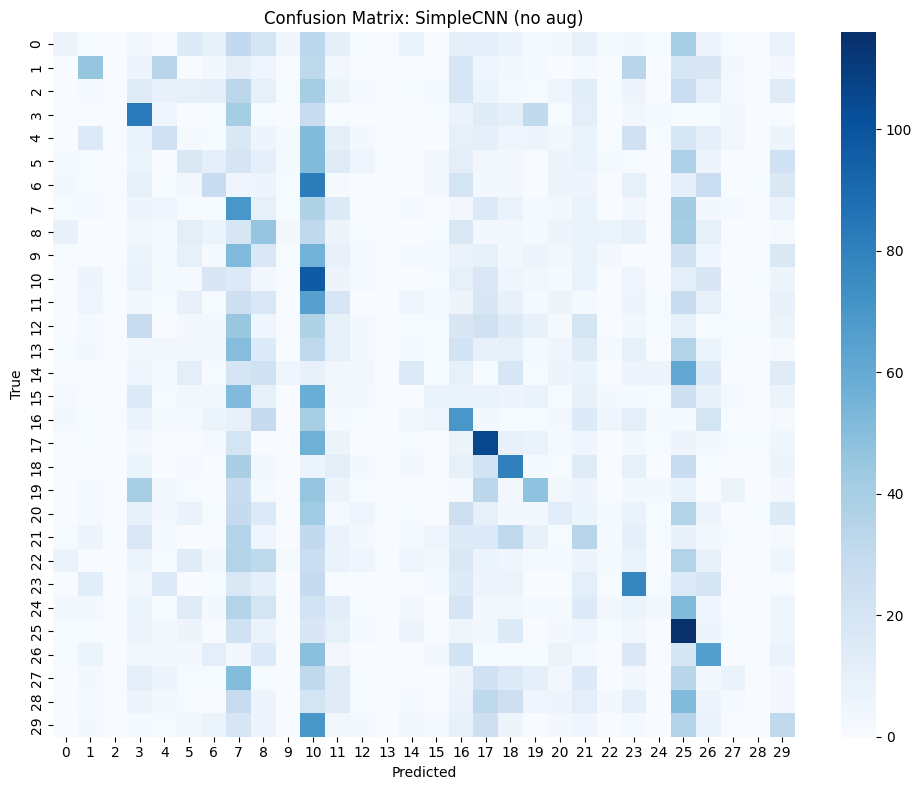

In [57]:

last = simple_hist[-1]
print({k: last[k] for k in ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "val_macro_f1"]})
plot_confusion(last['val_targets'], last["val_preds"], CLASS_NAMES, title="Confusion Matrix: SimpleCNN (no aug)")

Running all 3 models together and plotting the results -DANGER TAKES A LONG TIME

In [ ]:
# Run: scratch / transfer / finetune for both settings and compare macro-F1
results_noaug, history_noaug = train_regimes(train_loader_noaug, val_loader_noaug, num_classes, IMAGE_SIZE)
results_aug, history_aug  = train_regimes(train_loader_aug,   val_loader_aug,   num_classes, IMAGE_SIZE)


[scratch] Epoch 1/30 | train_loss=3.3035 acc=0.079 | val_loss=3.2190 acc=0.113 macroF1=0.075
[scratch] Epoch 2/30 | train_loss=3.2151 acc=0.111 | val_loss=3.1549 acc=0.128 macroF1=0.093
[scratch] Epoch 3/30 | train_loss=3.1633 acc=0.125 | val_loss=3.1047 acc=0.144 macroF1=0.101
[scratch] Epoch 4/30 | train_loss=3.1266 acc=0.138 | val_loss=3.0738 acc=0.150 macroF1=0.110
[scratch] Epoch 5/30 | train_loss=3.0977 acc=0.146 | val_loss=3.0295 acc=0.168 macroF1=0.136
[scratch] Epoch 6/30 | train_loss=3.0804 acc=0.148 | val_loss=3.0198 acc=0.167 macroF1=0.138
[scratch] Epoch 7/30 | train_loss=3.0652 acc=0.155 | val_loss=3.0188 acc=0.164 macroF1=0.132
[scratch] Epoch 8/30 | train_loss=3.0537 acc=0.158 | val_loss=2.9974 acc=0.172 macroF1=0.139
[scratch] Epoch 9/30 | train_loss=3.0420 acc=0.164 | val_loss=2.9742 acc=0.182 macroF1=0.155
[scratch] Epoch 10/30 | train_loss=3.0328 acc=0.163 | val_loss=2.9705 acc=0.180 macroF1=0.156
[scratch] Epoch 11/30 | train_loss=3.0260 acc=0.165 | val_loss=2.9654

TypeError: 'SimpleCNN' object is not subscriptable

Macro-F1 (no aug): {'scratch': 0.20269374846695004, 'transfer': 0.6537521704335467, 'finetune': 0.8560410153781324}
Macro-F1 (aug): {'scratch': 0.16744002278187275, 'transfer': 0.6824734347583336, 'finetune': 0.8717408665481433}


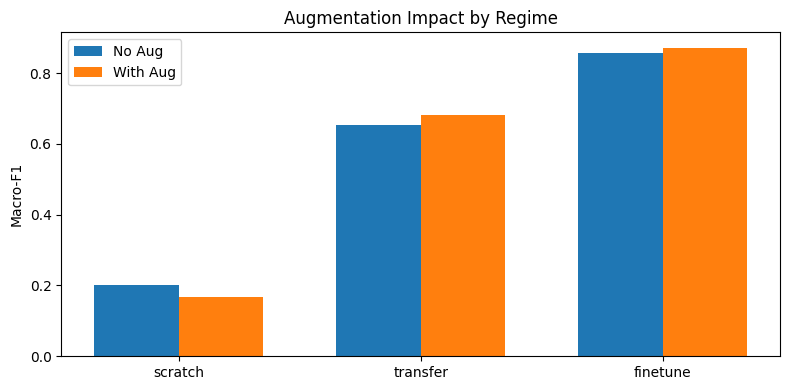

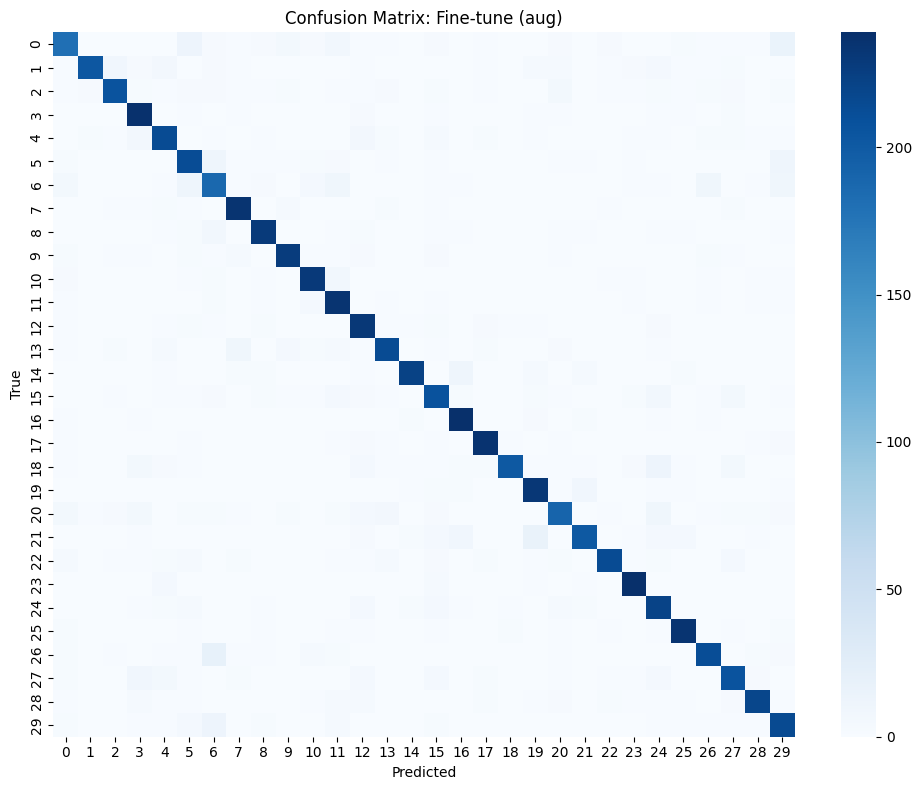

In [34]:
# Collect macro-F1 from the last epoch of each regime
regimes = ["scratch", "transfer", "finetune"]
macroF1_noaug = {k: history_noaug[k][-1]["val_macro_f1"] for k in regimes}
macroF1_aug   = {k: history_aug[k][-1]["val_macro_f1"]   for k in regimes}

print("Macro-F1 (no aug):", macroF1_noaug)
print("Macro-F1 (aug):", macroF1_aug)

# Plot comparison
labels = regimes
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - width/2, [macroF1_noaug[k] for k in labels], width, label='No Aug')
plt.bar(x + width/2, [macroF1_aug[k] for k in labels], width, label='With Aug')
plt.xticks(x, labels)
plt.ylabel('Macro-F1')
plt.title('Augmentation Impact by Regime')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix for best model (aug + finetune)
va_best = history_aug['finetune'][-1]
plot_confusion(va_best["val_targets"], va_best["val_preds"], CLASS_NAMES, title="Confusion Matrix: Fine-tune (aug)")


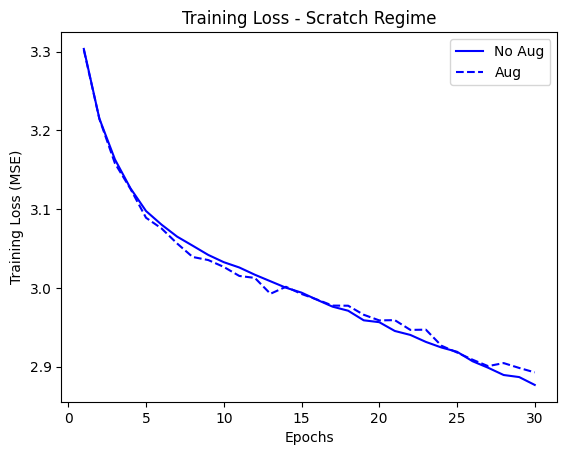

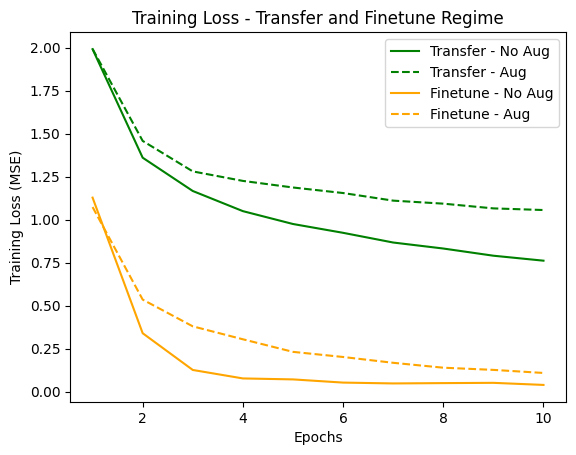

In [74]:
# plotting training loss across epochs for each regime
train_loss_scratch = {'noaug': [], 'aug': []}
train_loss_transfer = {'noaug': [], 'aug': []}
train_loss_finetune = {'noaug': [], 'aug': []}

# scratch regime
for i in range(30):
    train_loss_scratch['noaug'].append(history_noaug['scratch'][i]['train_loss'])
    train_loss_scratch['aug'].append(history_aug['scratch'][i]['train_loss'])

# transfer and finetune regime
for i in range(10):
    train_loss_transfer['noaug'].append(history_noaug['transfer'][i]['train_loss'])
    train_loss_transfer['aug'].append(history_aug['transfer'][i]['train_loss'])
    train_loss_finetune['noaug'].append(history_noaug['finetune'][i]['train_loss'])
    train_loss_finetune['aug'].append(history_aug['finetune'][i]['train_loss'])

plt.figure(1) # Assigns a figure number for identification
epochs = np.arange(30)+1
plt.plot(epochs, train_loss_scratch['noaug'], color='blue')
plt.plot(epochs, train_loss_scratch['aug'], color='blue', linestyle='--')
plt.title('Training Loss - Scratch Regime')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.legend(['No Aug', 'Aug'])

plt.figure(2) # Assigns a figure number for identification
epochs = np.arange(10)+1
plt.plot(epochs, train_loss_transfer['noaug'], color='green')
plt.plot(epochs, train_loss_transfer['aug'], color='green', linestyle='--')
plt.plot(epochs, train_loss_finetune['noaug'], color='orange')
plt.plot(epochs, train_loss_finetune['aug'], color='orange', linestyle='--')
plt.title('Training Loss - Transfer and Finetune Regime')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.legend(['Transfer - No Aug', 'Transfer - Aug', 'Finetune - No Aug', 'Finetune - Aug'])




# Questions
## Baseline vs. Transfer vs. Fine-Tune
It can be observed that the baseline model performs the worst, followed by the transfer and fine-tune models, by their respective macro-F1 scores. Furthermore, this pattern is observed across all three models for their respective training loss. This makes sense since the model needs more time and training data to optimize its weights when training from scratch, whereas transfered models or fine-tuned models have already been moderately optimized. Fine-tuning performs better than the transfer learning model because it has a deeper network, allowing it to easily more classification regimes.

## Data Augmentation
All three regimes have a similar training loss descent, yet the transfer and fine-tune models without data augmentation have a lower loss than their data-augmented counterparts. This could be because adding augmented samples makes it harder for the model to learn/generalize across varying samples, leading to a higher loss.

An interesting observation is that including augmented samples when training from scratch decreased the macro-F1 score. However, this could be attributed to only training the model over 30 epochs since having a larger variance across samples may take longer to learn. In both the
transfer and fine-tune regime, adding augmented samples slightly improved the overall macro-F1 score.

If class-aware sampling or loss weighting was used, then the model would be more agnostic to an uneven distribution of classes by emphasizing the minority classes more. This may result in an initial higher loss, similar to the loss change seen with data augmentation, but in an overall better equipped model.